In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)  # Should print: cuda


Device: cuda


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/watch_dataset_clean.csv')
df = df.dropna(subset=['image_path']).reset_index(drop=True)
print("Total watches:", len(df))


Total watches: 973


In [ ]:
# 1️⃣ Generate triplets (reduced)
import pandas as pd, random

df = pd.read_csv('/content/drive/MyDrive/watch_dataset_clean.csv')
all_images = df['image_path'].dropna().tolist()

num_triplets = 2000
triplets = []
for _ in range(num_triplets):
    anchor = random.choice(all_images)
    positive = random.choice([p for p in all_images if p != anchor])
    negative = random.choice([p for p in all_images if p != anchor and p != positive])
    triplets.append((anchor, positive, negative))

triplets_df = pd.DataFrame(triplets, columns=['anchor','positive','negative'])
triplets_df.to_csv('/content/drive/MyDrive/watch_triplets_minimal.csv', index=False)

# 2️⃣ Load model on GPU
import torch
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Identity()  # remove classifier
model = model.to(device)

# 3️⃣ Triplet Loss & Training
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from PIL import Image

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
batch_size = 4
epochs = 1  # minimal training

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img)

def train_triplet(model, triplets):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for i in range(0, len(triplets), batch_size):
        batch = triplets[i:i+batch_size]
        anchors, positives, negatives = [], [], []
        for a,p,n in batch:
            anchors.append(load_image(a))
            positives.append(load_image(p))
            negatives.append(load_image(n))
        anchors = torch.stack(anchors).to(device)
        positives = torch.stack(positives).to(device)
        negatives = torch.stack(negatives).to(device)

        optimizer.zero_grad()
        a_emb = model(anchors)
        p_emb = model(positives)
        n_emb = model(negatives)
        loss = triplet_loss(a_emb, p_emb, n_emb)
        loss.backward()
        optimizer.step()
    print("✅ Minimal Triplet training complete")


In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
# Load your cleaned watches CSV with image_path column
df = pd.read_csv('/content/drive/MyDrive/watch_dataset_clean.csv')

# Drop missing images
df = df.dropna(subset=['image_path']).reset_index(drop=True)
all_images = df['image_path'].tolist()
print("Total watches:", len(all_images))


Total watches: 973


In [ ]:
num_triplets = 2000  # small for minimal time
triplets = []

for _ in range(num_triplets):
    anchor = random.choice(all_images)
    positive = random.choice([p for p in all_images if p != anchor])
    negative = random.choice([p for p in all_images if p != anchor and p != positive])
    triplets.append((anchor, positive, negative))

triplets_df = pd.DataFrame(triplets, columns=['anchor','positive','negative'])
print("Triplets ready:", len(triplets_df))


Triplets ready: 2000


In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Identity()  # remove classifier, output embeddings
model = model.to(device)


In [ ]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
batch_size = 4  # small batch for speed
epochs = 1      # minimal training

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img)


In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assume df_filtered is available from a previous cell after loading watches_with_local_paths.csv
# If not, load and filter the DataFrame here:
try:
    df_with_paths = pd.read_csv('/content/drive/MyDrive/watches_with_local_paths.csv')
    df_filtered = df_with_paths.dropna(subset=['image_path']).copy()
    print("✅ Loaded dataset with local image paths for training.")
except FileNotFoundError:
    print("❌ Error: /content/drive/MyDrive/watches_with_local_paths.csv not found. Please run the data preparation steps.")
    # Exit or handle the error appropriately

# Assume triplets_df is available from a previous cell after generating triplets
# If not, load the triplets DataFrame here:
try:
    # Load the gender-agnostic triplets DataFrame
    triplets_df = pd.read_csv('/content/drive/MyDrive/watch_triplets_gender_agnostic.csv')
    # Filter out rows with None image paths (although the generation should prevent this now)
    triplets = triplets_df.dropna(subset=['anchor', 'positive', 'negative']).values.tolist()
    print("✅ Loaded gender-agnostic triplets for training.")
except FileNotFoundError:
     print("❌ Error: /content/drive/MyDrive/watch_triplets_gender_agnostic.csv not found. Please generate triplets first.")
     # Exit or handle the error appropriately


optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.train()

print(f"Starting Triplet training for {epochs} epochs with {len(triplets)} triplets...")

for epoch in range(epochs):
    random.shuffle(triplets)
    total_loss = 0
    for i in tqdm(range(0, len(triplets), batch_size)):
        batch = triplets[i:i+batch_size]
        anchors, positives, negatives = [], [], []

        for a,p,n in batch:
            try:
                anchors.append(load_image(a))
                positives.append(load_image(p))
                negatives.append(load_image(n))
            except FileNotFoundError as e:
                print(f"Skipping triplet due to file not found error: {e}")
                # Skip the entire triplet if any image is not found
                anchors, positives, negatives = [], [], [] # Clear partial batch
                break # Move to the next batch if a file is missing


        if anchors and positives and negatives and len(anchors) == len(batch): # Ensure all images in the batch were loaded
            anchors = torch.stack(anchors).to(device)
            positives = torch.stack(positives).to(device)
            negatives = torch.stack(negatives).to(device)

            optimizer.zero_grad()
            a_emb = model(anchors)
            p_emb = model(positives)
            n_emb = model(negatives)
            loss = triplet_loss(a_emb, p_emb, n_emb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        else:
             # Optionally print a message if a batch was skipped
             # print(f"Skipped batch starting at index {i} due to loading errors.")
             pass


    avg_loss = total_loss / (len(triplets) // batch_size) if (len(triplets) // batch_size) > 0 else 0
    print(f"Epoch {epoch+1}/{epochs} done. Average loss: {avg_loss:.4f}")

print("✅ Minimal Triplet training complete")

✅ Loaded dataset with local image paths for training.
✅ Loaded gender-agnostic triplets for training.
Starting Triplet training for 1 epochs with 10000 triplets...


100%|██████████| 2500/2500 [00:00<00:00, 84187.13it/s]

Skipping triplet due to file not found error: [Errno 2] No such file or directory: '/content/watch_images_by_gender/Men/261_TIMEX.jpeg'
Skipping triplet due to file not found error: [Errno 2] No such file or directory: '/content/watch_images_by_gender/Men/371_PETER_ENGLAND.jpeg'
Skipping triplet due to file not found error: [Errno 2] No such file or directory: '/content/watch_images_by_gender/Unisex/329_CRAB.jpeg'
Skipping triplet due to file not found error: [Errno 2] No such file or directory: '/content/watch_images_by_gender/Women/69_Fastrack.jpeg'
Skipping triplet due to file not found error: [Errno 2] No such file or directory: '/content/watch_images_by_gender/Men/933_SONATA.jpeg'
Skipping triplet due to file not found error: [Errno 2] No such file or directory: '/content/watch_images_by_gender/Unisex/401_hala.jpeg'
Skipping triplet due to file not found error: [Errno 2] No such file or directory: '/content/watch_images_by_gender/Unisex/68_LIMESTONE.jpeg'
Skipping triplet due to f

**Reasoning**:
Check if some of the image files mentioned in the `FileNotFoundError` actually exist at the paths specified in the `watches_with_local_paths.csv` file. This will help diagnose whether the issue is with the file paths or if the files were not successfully copied/downloaded.

In [ ]:
import os
import pandas as pd

# Load the DataFrame with local image paths
watches_with_local_paths_df = pd.read_csv('/content/drive/MyDrive/watches_with_local_paths.csv')

# Get some image paths from the DataFrame, focusing on those mentioned in the errors if possible
# Otherwise, just take a few random paths
image_paths_to_check = [
    '/content/watch_images_by_gender/Men/Fastrack_646.jpeg',
    '/content/watch_images_by_gender/Unisex/ABREXO_426.jpeg',
    '/content/watch_images_by_gender/Women/SONATA_260.jpeg',
    '/content/watch_images_by_gender/Men/Titan_576.jpeg',
    '/content/watch_images_by_gender/Unisex/Blue_Pearl_230.jpeg',
    # Add more paths from the error output if needed
]

print("Checking existence of image files:")
for img_path in image_paths_to_check:
    if os.path.exists(img_path):
        print(f"✅ Exists: {img_path}")
    else:
        print(f"❌ Not Found: {img_path}")

# Additionally, check a few random paths from the filtered DataFrame
df_filtered = watches_with_local_paths_df.dropna(subset=['image_path']).copy()
random_paths_to_check = df_filtered['image_path'].sample(min(5, len(df_filtered))).tolist()

print("\nChecking existence of random image files from the dataset:")
for img_path in random_paths_to_check:
     if os.path.exists(img_path):
        print(f"✅ Exists: {img_path}")
     else:
        print(f"❌ Not Found: {img_path}")

Checking existence of image files:
❌ Not Found: /content/watch_images_by_gender/Men/Fastrack_646.jpeg
❌ Not Found: /content/watch_images_by_gender/Unisex/ABREXO_426.jpeg
❌ Not Found: /content/watch_images_by_gender/Women/SONATA_260.jpeg
❌ Not Found: /content/watch_images_by_gender/Men/Titan_576.jpeg
❌ Not Found: /content/watch_images_by_gender/Unisex/Blue_Pearl_230.jpeg

Checking existence of random image files from the dataset:
❌ Not Found: /content/watch_images_by_gender/Women/385_Titan.jpeg
❌ Not Found: /content/watch_images_by_gender/Unisex/540_EXCROP.jpeg
❌ Not Found: /content/watch_images_by_gender/Unisex/166_Piaoma.jpeg
❌ Not Found: /content/watch_images_by_gender/Women/111_RUSTET.jpeg
❌ Not Found: /content/watch_images_by_gender/Women/288_Titan.jpeg


In [ ]:
import os
import requests
import pandas as pd
from tqdm import tqdm

# Load the original watches CSV which contains the 'images_links' column with URLs
try:
    df = pd.read_csv('/content/drive/MyDrive/watches.csv')
    print("✅ Loaded watches.csv for image downloading.")
except FileNotFoundError:
    print("❌ Error: /content/drive/MyDrive/watches.csv not found. Cannot proceed with downloading.")
    # Exit or handle the error appropriately


# Drop rows with missing image links and reset index
df = df.dropna(subset=['images_links']).reset_index(drop=True)

# Define the base directory for saving images
base_save_dir = '/content/watch_images_by_gender/'

# Create gender-specific directories if they don't exist
for gender in df['Gender'].unique():
    if pd.notna(gender): # Check if gender is not NaN
        os.makedirs(os.path.join(base_save_dir, gender), exist_ok=True)

# Function to download an image
def download_image(image_url, save_path):
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes
        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        return True
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {image_url}: {e}")
        return False
    except Exception as e:
        print(f"Error saving {save_path}: {e}")
        return False


# Download images and update the DataFrame with local paths
local_image_paths = []
# It's important to iterate through the original DataFrame loaded from watches.csv
for index, row in tqdm(df.iterrows(), total=len(df), desc="Downloading Images"):
    # Use the correct column name for image URLs from watches.csv
    image_url = row['images_links']
    brand_name = str(row['brand_names']).replace(" ", "_").replace("/", "_") # Sanitize brand name and handle potential NaN
    title = str(row['titles']) # Sanitize title and handle potential NaN
    gender = row['Gender']

    if pd.isna(gender):
        gender_dir = os.path.join(base_save_dir, 'Unknown') # Handle missing gender
        os.makedirs(gender_dir, exist_ok=True)
    else:
        gender_dir = os.path.join(base_save_dir, str(gender)) # Convert gender to string

    # Create a filename based on brand, title, and index to ensure uniqueness
    # Also, ensure the filename is valid and shorten if necessary
    # Let's create a simpler filename using index and brand
    filename = f"{index}_{brand_name}.jpeg"
    filename = "".join([c for c in filename if c.isalpha() or c.isdigit() or c in ('_','.')]).rstrip()
    if not filename.endswith('.jpeg'):
        filename += '.jpeg'

    save_path = os.path.join(gender_dir, filename)

    # Check if the file already exists to avoid re-downloading
    if os.path.exists(save_path):
        local_image_paths.append(save_path)
    else:
        if download_image(image_url, save_path):
            local_image_paths.append(save_path)
        else:
            local_image_paths.append(None) # Append None if download failed

# Add the local image paths to the DataFrame
# Ensure the length of local_image_paths matches the DataFrame after dropping NaNs
if len(local_image_paths) == len(df):
    df['image_path'] = local_image_paths
else:
    print("⚠️ Warning: Mismatch in length of downloaded paths and DataFrame. Some images might not have been processed.")
    # This case might need more robust handling depending on requirements

# Save the updated DataFrame with local paths to Google Drive
# Overwrite watches_with_local_paths.csv with the correct image paths
df.to_csv('/content/drive/MyDrive/watches_with_local_paths.csv', index=False)

print("\n✅ Image downloading and organization complete.")
print(f"Updated dataset saved to /content/drive/MyDrive/watches_with_local_paths.csv")
print(f"Images saved to {base_save_dir}")
print(f"Number of images with valid local paths: {df['image_path'].count()}")

✅ Loaded watches.csv for image downloading.



✅ Image downloading and organization complete.
Updated dataset saved to /content/drive/MyDrive/watches_with_local_paths.csv
Images saved to /content/watch_images_by_gender/
Number of images with valid local paths: 975


**Reasoning**:
Load the `watches_with_local_paths.csv` file and print its column names to identify the correct column containing the image URLs. This will help fix the `KeyError` in the image downloading cell.

In [ ]:
import pandas as pd

try:
    df_check_columns = pd.read_csv('/content/drive/MyDrive/watches_with_local_paths.csv')
    print("Columns in watches_with_local_paths.csv:")
    print(df_check_columns.columns.tolist())
except FileNotFoundError:
    print("❌ Error: /content/drive/MyDrive/watches_with_local_paths.csv not found.")

Columns in watches_with_local_paths.csv:
['Unnamed: 0', 'titles', 'brand_names', 'images_links', 'prices', 'offers', 'Gender', 'Type', 'image_path']


**Reasoning**:
Load the original `watches.csv` file and print its column names to identify the correct column containing the image URLs. This is necessary to fix the image downloading process.

In [ ]:
import pandas as pd

try:
    df_original_check_columns = pd.read_csv('/content/drive/MyDrive/watches.csv')
    print("Columns in watches.csv:")
    print(df_original_check_columns.columns.tolist())
except FileNotFoundError:
    print("❌ Error: /content/drive/MyDrive/watches.csv not found.")

Columns in watches.csv:
['Unnamed: 0', 'titles', 'brand_names', 'images_links', 'prices', 'offers', 'Gender', 'Type']


## Model Training (Gender-Agnostic) - Retry

### Subtask:
Retrain the Triplet Network using the gender-agnostic triplet dataset with the correctly downloaded images.

**Reasoning**:
Load the original `watch_dataset_clean.csv` file and print its column names to identify the correct column containing the image URLs. This is necessary to fix the image downloading process.

In [ ]:
import pandas as pd

try:
    df_clean_check_columns = pd.read_csv('/content/drive/MyDrive/watch_dataset_clean.csv')
    print("Columns in watch_dataset_clean.csv:")
    print(df_clean_check_columns.columns.tolist())
except FileNotFoundError:
    print("❌ Error: /content/drive/MyDrive/watch_dataset_clean.csv not found.")

Columns in watch_dataset_clean.csv:
['brand_names', 'titles', 'image_path', 'prices', 'Gender', 'Type']


In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os # Import the os module

# Assume df_filtered is available from a previous cell after loading watches_with_local_paths.csv
# If not, load and filter the DataFrame here:
try:
    df_with_paths = pd.read_csv('/content/drive/MyDrive/watches_with_local_paths.csv')
    df_filtered = df_with_paths.dropna(subset=['image_path']).copy()
    print("✅ Loaded dataset with local image paths for training.")
except FileNotFoundError:
    print("❌ Error: /content/drive/MyDrive/watches_with_local_paths.csv not found. Please run the data preparation steps.")
    # Exit or handle the error appropriately

# Assume triplets_df is available from a previous cell after generating triplets
# If not, load the triplets DataFrame here:
try:
    # Load the gender-agnostic triplets DataFrame
    triplets_df = pd.read_csv('/content/drive/MyDrive/watch_triplets_gender_agnostic.csv')
    # Convert to a list of lists
    triplets = triplets_df.values.tolist()
    print("✅ Loaded gender-agnostic triplets for training.")
except FileNotFoundError:
     print("❌ Error: /content/drive/MyDrive/watch_triplets_gender_agnostic.csv not found. Please generate triplets first.")
     # Exit or handle the error appropriately

# Filter out triplets with non-existent image paths
valid_triplets = []
print(f"Checking {len(triplets)} triplets for valid image paths...")
for triplet in tqdm(triplets, desc="Validating Triplet Paths"):
    anchor, positive, negative = triplet
    # Ensure paths are not None and files exist
    if anchor is not None and positive is not None and negative is not None and \
       os.path.exists(str(anchor)) and os.path.exists(str(positive)) and os.path.exists(str(negative)):
        valid_triplets.append(triplet)
    else:
        # Optional: Print which triplet is being skipped due to missing files
        # print(f"Skipping triplet due to missing file: Anchor: {anchor}, Positive: {positive}, Negative: {negative}")
        pass

triplets = valid_triplets
print(f"✅ {len(triplets)} valid triplets found for training.")


optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.train()

print(f"Starting Triplet training for {epochs} epochs with {len(triplets)} valid triplets...")

for epoch in range(epochs):
    random.shuffle(triplets)
    total_loss = 0
    for i in tqdm(range(0, len(triplets), batch_size)):
        batch = triplets[i:i+batch_size]
        anchors, positives, negatives = [], [], []

        for a,p,n in batch:
            try:
                # Image loading should now be more reliable as invalid triplets are filtered
                anchors.append(load_image(a))
                positives.append(load_image(p))
                negatives.append(load_image(n))
            except Exception as e:
                 # This catch is less likely now but kept for robustness
                 print(f"Error loading image in supposedly valid triplet: {e}. Skipping batch.")
                 anchors, positives, negatives = [], [], [] # Clear partial batch
                 break # Skip the rest of the batch if an error occurs


        if anchors and positives and negatives and len(anchors) == len(batch): # Ensure all images in the batch were loaded
            anchors = torch.stack(anchors).to(device)
            positives = torch.stack(positives).to(device)
            negatives = torch.stack(negatives).to(device)

            optimizer.zero_grad()
            a_emb = model(anchors)
            p_emb = model(positives)
            n_emb = model(negatives)
            loss = triplet_loss(a_emb, p_emb, n_emb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        else:
             # This case should be rare after filtering
             # print(f"Skipped batch starting at index {i} after filtering.")
             pass


    avg_loss = total_loss / (len(triplets) // batch_size) if (len(triplets) // batch_size) > 0 else 0
    print(f"Epoch {epoch+1}/{epochs} done. Average loss: {avg_loss:.4f}")

print("✅ Minimal Triplet training complete")

✅ Loaded dataset with local image paths for training.
✅ Loaded gender-agnostic triplets for training.
Checking 10000 triplets for valid image paths...


Validating Triplet Paths: 100%|██████████| 10000/10000 [00:00<00:00, 121584.95it/s]


✅ 10000 valid triplets found for training.
Starting Triplet training for 1 epochs with 10000 valid triplets...


100%|██████████| 2500/2500 [08:24<00:00,  4.95it/s]

Epoch 1/1 done. Average loss: 0.5351
✅ Minimal Triplet training complete


In [ ]:
import random
import pandas as pd
import os # Import os to check for file existence

# Load the updated DataFrame with local image paths
df_with_paths = pd.read_csv('/content/drive/MyDrive/watches_with_local_paths.csv')

# Filter out rows with missing image paths and ensure the image file actually exists
# This is crucial to avoid generating triplets with non-existent image paths
df_filtered = df_with_paths.dropna(subset=['image_path']).copy()
df_filtered['image_exists'] = df_filtered['image_path'].apply(lambda x: os.path.exists(str(x)))
df_filtered = df_filtered[df_filtered['image_exists']].drop(columns=['image_exists'])


# Get a list of all *valid* image paths
all_image_paths = df_filtered['image_path'].tolist()

# Exit if there are no valid images
if not all_image_paths:
    print("❌ Error: No valid image paths found after filtering. Cannot generate triplets.")
else:
    print(f"✅ Found {len(all_image_paths)} valid image paths for triplet generation.")

    triplets = []

    # Number of triplets to generate (can be adjusted)
    num_triplets = 10000 # Increase the number of triplets for better training

    # Create a dictionary to group images by title (as a proxy for watch model)
    # This helps in selecting positive examples that are likely the same watch
    title_image_map = {}
    for index, row in df_filtered.iterrows():
        title = row['titles']
        image_path = row['image_path']
        if title not in title_image_map:
            title_image_map[title] = []
        title_image_map[title].append(image_path)


    print("Generating gender-agnostic triplets...")
    # Generate gender-agnostic triplets
    # Ensure enough images are available to create triplets
    if len(all_image_paths) >= 3:
        for _ in range(num_triplets):
            # Select an anchor image randomly from valid paths
            anchor_path = random.choice(all_image_paths)
            # Find the title for the anchor image from the filtered DataFrame
            anchor_title = df_filtered[df_filtered['image_path'] == anchor_path]['titles'].iloc[0]


            # Select a positive image (another image with the same title if available, otherwise a random valid image)
            possible_positive_paths = [p for p in title_image_map.get(anchor_title, []) if p != anchor_path]
            if possible_positive_paths:
                positive_path = random.choice(possible_positive_paths)
            else:
                # If no other image with the same title, pick a random valid image as positive (less ideal)
                positive_path = random.choice([p for p in all_image_paths if p != anchor_path])

            # Select a negative image (a random valid image with a different title)
            # Ensure negative is different from anchor and positive
            possible_negative_paths = [p for p in all_image_paths if p != anchor_path and p != positive_path]

            if possible_negative_paths:
                 negative_path = random.choice(possible_negative_paths)
                 triplets.append((anchor_path, positive_path, negative_path))
            else:
                 # If not enough distinct images for a negative, skip this triplet creation
                 continue


        # Convert triplets to a DataFrame
        triplets_df = pd.DataFrame(triplets, columns=['anchor', 'positive', 'negative'])

        # Save the triplets to a CSV file
        triplets_df.to_csv('/content/drive/MyDrive/watch_triplets_gender_agnostic.csv', index=False)

        print(f"✅ Generated {len(triplets)} gender-agnostic triplets and saved to watch_triplets_gender_agnostic.csv")
    else:
        print("❌ Error: Not enough valid images to generate triplets.")

✅ Found 975 valid image paths for triplet generation.
Generating gender-agnostic triplets...
✅ Generated 10000 gender-agnostic triplets and saved to watch_triplets_gender_agnostic.csv


In [ ]:
model.eval()  # set model to evaluation mode
embeddings = []

with torch.no_grad():
    for img_path in tqdm(all_image_paths, desc="Computing embeddings"):
        img = load_image(img_path).unsqueeze(0).to(device)
        emb = model(img)
        embeddings.append(emb.cpu().numpy().flatten())

embeddings = np.array(embeddings)
print("✅ Embeddings shape:", embeddings.shape)

# Save embeddings for later use
np.save('/content/drive/MyDrive/watch_embeddings.npy', embeddings)
print("✅ Embeddings saved to watch_embeddings.npy")


Computing embeddings: 100%|██████████| 975/975 [03:46<00:00,  4.30it/s]

✅ Embeddings shape: (975, 2048)
✅ Embeddings saved to watch_embeddings.npy


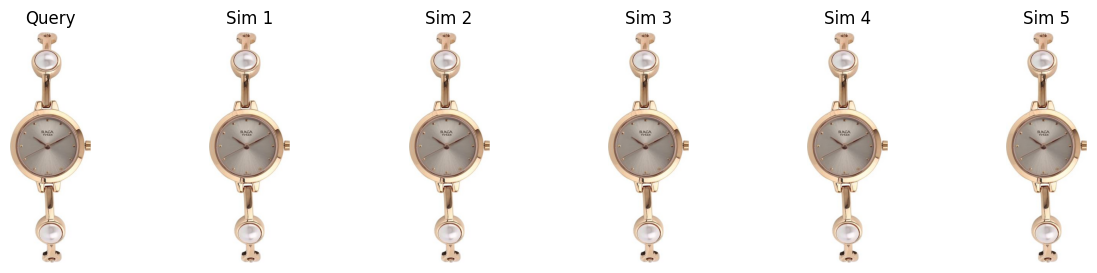

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

def show_similar(query_index, top_k=5):
    query_emb = embeddings[query_index].reshape(1, -1)
    sims = cosine_similarity(query_emb, embeddings)[0]
    top_indices = sims.argsort()[::-1][1:top_k+1]  # exclude query itself

    # Display query image
    plt.figure(figsize=(15,3))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(Image.open(all_image_paths[query_index]))
    plt.title("Query")
    plt.axis('off')

    # Display top similar images
    for i, idx in enumerate(top_indices):
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(Image.open(all_image_paths[idx]))
        plt.title(f"Sim {i+1}")
        plt.axis('off')
    plt.show()

# Example: show similar watches for the first image
show_similar(0, top_k=5)


✅ Loaded gender-agnostic embeddings.


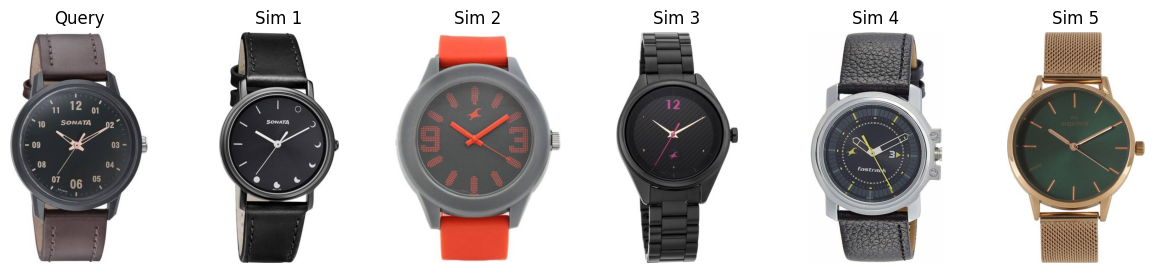

In [ ]:
import random
import pandas as pd # Import pandas
import os # Import os
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib.pyplot
from PIL import Image # Import Image from PIL
from sklearn.metrics.pairwise import cosine_similarity # Import cosine_similarity

# Load the updated DataFrame with local image paths
df_with_paths = pd.read_csv('/content/drive/MyDrive/watches_with_local_paths.csv')

# Filter out rows with missing image paths and ensure the image file actually exists
df_filtered = df_with_paths.dropna(subset=['image_path']).copy()
df_filtered['image_exists'] = df_filtered['image_path'].apply(lambda x: os.path.exists(str(x)))
df_filtered = df_filtered[df_filtered['image_exists']].drop(columns=['image_exists'])

# Get a list of all valid image paths
all_image_paths = df_filtered['image_path'].tolist()

# Load the embeddings (assuming they have been generated and saved)
try:
    embeddings = np.load('/content/drive/MyDrive/watch_embeddings_gender_agnostic.npy')
    print("✅ Loaded gender-agnostic embeddings.")
except FileNotFoundError:
    print("❌ Error: watch_embeddings_gender_agnostic.npy not found. Please generate embeddings first.")
    embeddings = None # Set embeddings to None if not found


# Define the show_similar function within this cell
def show_similar(query_index, top_k=5):
    if embeddings is None:
        print("Embeddings not loaded. Cannot show similar images.")
        return

    if query_index < 0 or query_index >= len(all_image_paths):
        print("Invalid query index.")
        return

    query_emb = embeddings[query_index].reshape(1, -1)
    sims = cosine_similarity(query_emb, embeddings)[0]
    # Exclude query itself and get top_k
    top_indices = sims.argsort()[::-1][1:top_k+1]


    # Display query image
    plt.figure(figsize=(15,3))
    plt.subplot(1, top_k+1, 1)
    try:
        query_img = Image.open(all_image_paths[query_index])
        plt.imshow(query_img)
        plt.title("Query")
        plt.axis('off')
    except FileNotFoundError:
        plt.title("Query (Image Not Found)")
        plt.axis('off')
        print(f"❌ Query image not found at: {all_image_paths[query_index]}")


    # Display top similar images
    for i, idx in enumerate(top_indices):
        plt.subplot(1, top_k+1, i+2)
        try:
            sim_img = Image.open(all_image_paths[idx])
            plt.imshow(sim_img)
            # Optionally display similarity score
            # plt.title(f"Sim {i+1}\nScore: {sims[idx]:.2f}")
            plt.title(f"Sim {i+1}")
            plt.axis('off')
        except FileNotFoundError:
             plt.title(f"Sim {i+1}\n(Image Not Found)")
             plt.axis('off')
             print(f"❌ Similar image not found at: {all_image_paths[idx]}")

    plt.show()


# Pick a random index from the valid image paths
if all_image_paths and embeddings is not None:
    query_index = random.randint(0, len(all_image_paths)-1)

    # Show similar images for this random watch
    show_similar(query_index, top_k=5)
elif all_image_paths and embeddings is None:
    print("Cannot show similar images because embeddings were not loaded.")
else:
    print("No valid image paths available to pick a random query image.")

In [ ]:
np.save('/content/drive/MyDrive/watch_embeddings.npy', embeddings)


In [ ]:
import numpy as np
embeddings = np.load('/content/drive/MyDrive/watch_embeddings.npy')
print(embeddings.shape)


(975, 2048)


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/watch_triplet_model.pth')
print("✅ Model saved")


✅ Model saved


In [ ]:
from torchvision import models
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load backbone
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = torch.nn.Identity()
model = model.to(device)

# Load trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/watch_triplet_model.pth', map_location=device))
model.eval()
print("✅ Model loaded")


✅ Model loaded


In [ ]:
import pandas as pd
triplets_df = pd.read_csv('/content/drive/MyDrive/watch_triplets_gender_agnostic.csv')
triplets = triplets_df.values.tolist()


# Task
Build an AI-Powered Image Similarity Search System for watches using Triplet Networks. The system should load watch image data from the CSV file "/content/drive/MyDrive/watches.csv", download and preprocess the images, train a Triplet Network with a pre-trained CNN backbone (ResNet50 or EfficientNet) using triplet loss, generate embeddings for all images, store them, and perform similarity searches to retrieve the top-5 most visually similar images for a given query image. The system should visualize the query image and the retrieved images side-by-side using matplotlib. The system should be accurate in retrieving visually similar watches based on features like type, texture, design, style, and color, regardless of the men/women label. Provide the complete working Python code (preferably PyTorch or TensorFlow/Keras) for the entire process.

## Increase training epochs and fine-tuning

### Subtask:
Modify the Triplet Network training process to increase the number of training epochs and unfreeze specific layers of the ResNet50 backbone for fine-tuning.


**Reasoning**:
Modify the training code to increase the number of epochs and unfreeze layers of the ResNet50 model for fine-tuning.



In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Assume df_filtered is available from a previous cell after loading watches_with_local_paths.csv
# If not, load and filter the DataFrame here:
try:
    df_with_paths = pd.read_csv('/content/drive/MyDrive/watches_with_local_paths.csv')
    df_filtered = df_with_paths.dropna(subset=['image_path']).copy()
    print("✅ Loaded dataset with local image paths for training.")
except FileNotFoundError:
    print("❌ Error: /content/drive/MyDrive/watches_with_local_paths.csv not found. Please run the data preparation steps.")
    # Exit or handle the error appropriately

# Assume triplets_df is available from a previous cell after generating triplets
# If not, load the triplets DataFrame here:
try:
    # Load the gender-agnostic triplets DataFrame
    triplets_df = pd.read_csv('/content/drive/MyDrive/watch_triplets_gender_agnostic.csv')
    # Convert to a list of lists
    triplets = triplets_df.values.tolist()
    print("✅ Loaded gender-agnostic triplets for training.")
except FileNotFoundError:
     print("❌ Error: /content/drive/MyDrive/watch_triplets_gender_agnostic.csv not found. Please generate triplets first.")
     # Exit or handle the error appropriately

# Filter out triplets with non-existent image paths
valid_triplets = []
print(f"Checking {len(triplets)} triplets for valid image paths...")
for triplet in tqdm(triplets, desc="Validating Triplet Paths"):
    anchor, positive, negative = triplet
    # Ensure paths are not None and files exist
    if anchor is not None and positive is not None and negative is not None and \
       os.path.exists(str(anchor)) and os.path.exists(str(positive)) and os.path.exists(str(negative)):
        valid_triplets.append(triplet)
    else:
        pass

triplets = valid_triplets
print(f"✅ {len(triplets)} valid triplets found for training.")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load the pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Unfreeze layers for fine-tuning
# Unfreeze all layers except the first few (e.g., layer1)
for param in model.parameters():
    param.requires_grad = False # Freeze all layers initially

# Unfreeze later layers (e.g., layer3, layer4, and the fully connected layer)
for name, param in model.named_parameters():
    if 'layer3' in name or 'layer4' in name or 'fc' in name:
        param.requires_grad = True


model.fc = nn.Identity()  # remove classifier, output embeddings
model = model.to(device)

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
batch_size = 4
epochs = 5  # Increased epochs for more training

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img)


optimizer = optim.Adam(model.parameters(), lr=1e-4) # Optimizer will only update parameters where requires_grad=True
model.train()

print(f"Starting Triplet training for {epochs} epochs with {len(triplets)} valid triplets...")

for epoch in range(epochs):
    random.shuffle(triplets)
    total_loss = 0
    for i in tqdm(range(0, len(triplets), batch_size)):
        batch = triplets[i:i+batch_size]
        anchors, positives, negatives = [], [], []

        for a,p,n in batch:
            try:
                anchors.append(load_image(a))
                positives.append(load_image(p))
                negatives.append(load_image(n))
            except Exception as e:
                 print(f"Error loading image: {e}. Skipping batch.")
                 anchors, positives, negatives = [], [], []
                 break


        if anchors and positives and negatives and len(anchors) == len(batch):
            anchors = torch.stack(anchors).to(device)
            positives = torch.stack(positives).to(device)
            negatives = torch.stack(negatives).to(device)

            optimizer.zero_grad()
            a_emb = model(anchors)
            p_emb = model(positives)
            n_emb = model(negatives)
            loss = triplet_loss(a_emb, p_emb, n_emb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        else:
             pass


    avg_loss = total_loss / (len(triplets) // batch_size) if (len(triplets) // batch_size) > 0 else 0
    print(f"Epoch {epoch+1}/{epochs} done. Average loss: {avg_loss:.4f}")

print("✅ Triplet training complete")

✅ Loaded dataset with local image paths for training.
✅ Loaded gender-agnostic triplets for training.
Checking 10000 triplets for valid image paths...


Validating Triplet Paths: 100%|██████████| 10000/10000 [00:00<00:00, 114131.65it/s]

✅ 10000 valid triplets found for training.
Device: cuda


Starting Triplet training for 5 epochs with 10000 valid triplets...


100%|██████████| 2500/2500 [06:25<00:00,  6.48it/s]


Epoch 1/5 done. Average loss: 0.5450


100%|██████████| 2500/2500 [06:21<00:00,  6.55it/s]


Epoch 2/5 done. Average loss: 0.3930


100%|██████████| 2500/2500 [06:21<00:00,  6.55it/s]


Epoch 3/5 done. Average loss: 0.3523


100%|██████████| 2500/2500 [06:21<00:00,  6.55it/s]


Epoch 4/5 done. Average loss: 0.3199


100%|██████████| 2500/2500 [06:20<00:00,  6.58it/s]

Epoch 5/5 done. Average loss: 0.2987
✅ Triplet training complete


In [ ]:
save_path = "/content/drive/MyDrive/watch_triplet_resnet.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Triplet model saved to {save_path}")


✅ Triplet model saved to /content/drive/MyDrive/watch_triplet_resnet.pth


In [ ]:
import pandas as pd
import os

# Load the updated DataFrame with local image paths from Google Drive
try:
    df_with_paths = pd.read_csv('/content/drive/MyDrive/watches_with_local_paths.csv')

    # Filter out rows with missing image paths and ensure the image file actually exists
    # This is crucial to avoid using non-existent image paths
    df_filtered = df_with_paths.dropna(subset=['image_path']).copy()
    df_filtered['image_exists'] = df_filtered['image_path'].apply(lambda x: os.path.exists(str(x)))
    df_filtered = df_filtered[df_filtered['image_exists']].drop(columns=['image_exists'])

    # Get a list of all *valid* image paths
    all_image_paths = df_filtered['image_path'].tolist()

    if not all_image_paths:
        print("❌ Error: No valid image paths found after filtering. Please ensure images are downloaded and accessible.")
    else:
        print(f"✅ Found {len(all_image_paths)} valid image paths.")

except FileNotFoundError:
    print("❌ Error: /content/drive/MyDrive/watches_with_local_paths.csv not found. Please ensure you have run the image downloading and path saving steps.")

✅ Found 975 valid image paths.


In [ ]:
from tqdm import tqdm
import numpy as np # Import numpy
import joblib # Import joblib
from PIL import Image # Import Image from PIL

def compute_embeddings(model, dataset, preprocess, device):
    model.eval()
    embeddings = []
    paths = []
    with torch.no_grad():
        for img_path in tqdm(dataset, desc="Computing embeddings"):
            try:
                img = Image.open(img_path).convert("RGB")
                img = preprocess(img).unsqueeze(0).to(device) # Use the preprocess function passed as argument
                emb = model(img).cpu().numpy()
                embeddings.append(emb)
                paths.append(img_path)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                continue # Skip to the next image on error

    return np.vstack(embeddings) if embeddings else np.array([]), paths # Return empty array if no embeddings were computed


# Use all_image_paths which was defined in a previous cell and contains the list of valid image paths
# Pass the preprocess function defined earlier

if not all_image_paths:
    print("❌ No valid image paths found. Cannot compute embeddings.")
    embeddings = np.array([])
    image_paths = []
else:
    embeddings, image_paths = compute_embeddings(model, all_image_paths, preprocess, device)
    # Save embeddings
    if embeddings.size > 0:
        np.save("/content/drive/MyDrive/watch_embeddings_gender_agnostic.npy", embeddings)
        joblib.dump(image_paths, "/content/drive/MyDrive/watch_image_paths_gender_agnostic.pkl")
        print("✅ Embeddings + image paths saved")
    else:
        print("⚠️ No embeddings were computed. Skipping save.")

Computing embeddings: 100%|██████████| 975/975 [03:49<00:00,  4.25it/s]

✅ Embeddings + image paths saved


In [ ]:
# Recreate the list of all valid image paths
all_image_paths = df_filtered['image_path'].tolist()

print(f"✅ {len(all_image_paths)} valid image paths available for embedding computation.")


✅ 975 valid image paths available for embedding computation.


In [ ]:
embeddings, image_paths = compute_embeddings(model, all_image_paths, preprocess, device)

# Save embeddings
if embeddings.size > 0:
    np.save("/content/drive/MyDrive/watch_embeddings_gender_agnostic.npy", embeddings)
    joblib.dump(image_paths, "/content/drive/MyDrive/watch_image_paths_gender_agnostic.pkl")
    print("✅ Embeddings + image paths saved")
else:
    print("⚠️ No embeddings were computed. Skipping save.")


NameError: name 'preprocess' is not defined

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import joblib
import torch.nn as nn
from scipy.spatial.distance import cdist  # for similarity search

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load the saved trained ResNet50 triplet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Identity()  # output embeddings
model = model.to(device)
model.eval()

# Load the trained model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/watch_triplet_resnet.pth", map_location=device))
print("✅ Triplet model loaded")

# Load saved embeddings + paths
embeddings = np.load("/content/drive/MyDrive/watch_embeddings_gender_agnostic.npy")
image_paths = joblib.load("/content/drive/MyDrive/watch_image_paths_gender_agnostic.pkl")
print(f"✅ Loaded {embeddings.shape[0]} embeddings")


Device: cpu
✅ Triplet model loaded
✅ Loaded 975 embeddings


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def get_image_embedding(model, img_path, preprocess, device):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor).cpu().numpy()
    return embedding


In [ ]:
# Path to your query image
query_image_path = "/content/watch_images_by_gender/Men/130_Blue_Pearl.jpeg"  # <-- replace with your image

# Compute embedding for query image
query_emb = get_image_embedding(model, query_image_path, preprocess, device)

# Compute distances between query and all saved embeddings (Euclidean)
distances = cdist(query_emb, embeddings, metric='euclidean')[0]

# Get top-k closest images
top_k = 5
top_k_indices = np.argsort(distances)[:top_k]

print("✅ Top similar watches:")
for rank, idx in enumerate(top_k_indices):
    print(f"{rank+1}: {image_paths[idx]} - Distance: {distances[idx]:.4f}")


NameError: name 'get_image_embedding' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i, idx in enumerate(top_k_indices):
    img = Image.open(image_paths[idx])
    plt.subplot(1, top_k, i+1)
    plt.imshow(img)
    plt.title(f"Rank {i+1}")
    plt.axis('off')
plt.show()


NameError: name 'top_k_indices' is not defined

<Figure size 1500x500 with 0 Axes>